In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
DATAROOT = r'../模式识别实验课2023/课程实验说明/课题一-数据降维与分类实验/数据/'
wine_data = dict(
    red='winequality-red.csv',
    white='winequality-white.csv'
)
wine_data = dict(
    red=pd.read_csv(
        DATAROOT + wine_data['red'], 
        sep=';'
    ).to_numpy(),
    white=pd.read_csv(
        DATAROOT + wine_data['white'], 
        sep=';'
    ).to_numpy()
)

In [84]:
def PCA(data, n):
    mean = np.average(data, axis=0)
    S = np.sum([
        np.outer(x - mean, x - mean)
        for x in data
    ], axis=0)
    v, w = np.linalg.eig(S)
    reduced_data = np.concatenate([
        np.dot(w[:, 0:n].T, x - mean)[np.newaxis, :]
        for x in data
    ], axis=0)
    return reduced_data

In [ ]:
def LDA(data, label, n, c):
    sep_data = [
        data[np.where(label==i)[0]]
        for i in range(c)
    ]
    mean_t = np.average(data)
    mean = [
        np.average(x_i, axis=0)
        for x_i in sep_data
    ]
    Sw = np.sum([np.sum([
            np.outer((x - mean), (x - mean))
            for x in x_i
        ]) for x_i in sep_data
    ])
    Sb = np.sum([
        len(x_i) * np.outer(
            (mean_i - mean_t), 
            (mean_i - mean_t)
        )
        for x_i, mean_i in zip(sep_data, mean)
    ])
    

In [95]:
a = np.array([1, 2, 2, 3, 1, 3, 2, 1])
a[np.array([1, 2, 3])]

array([2, 2, 3])

In [85]:
tmp = PCA(wine_data['red'][:, 0:11], 2)

/tmp/ipykernel_11540/1338853487.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


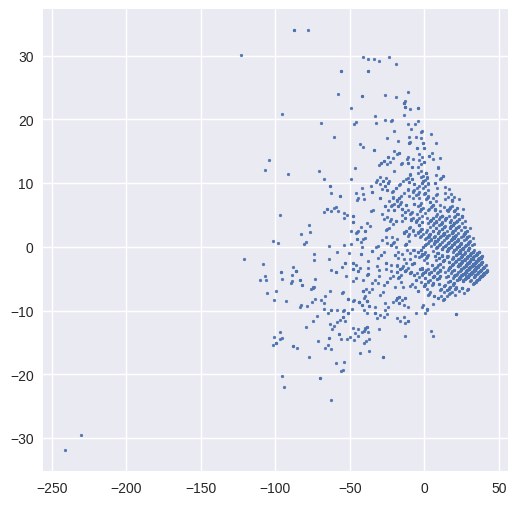

In [87]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(tmp[:, 0], tmp[:, 1], s=4)
plt.show()